In [7]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [8]:
import numpy as np
import pandas as pd

In [9]:
import datetime as dt

In [10]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [11]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [12]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [13]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [14]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [15]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()

In [17]:
print(prev_year)

2016-08-23


In [18]:
df = pd.DataFrame(results, columns=['date', 'precipitation'])
df.set_index(df['date'], inplace = True)
df = df[["precipitation"]]
df.head(5)

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


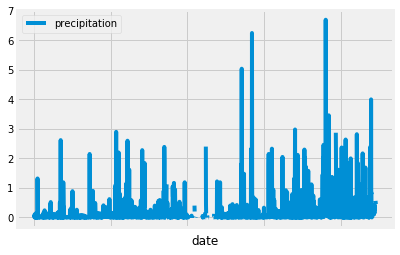

In [19]:
df.plot(x_compat=True)

In [20]:
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [21]:
station = session.query(func.count(Station.station)).all()
station

[(9)]

In [22]:
StationCount = session.query(Measurement.station, func.count(Measurement.station)).\
               group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
StationCount

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
temperature = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
              filter(Measurement.station == 'USC00519281').all()
temperature

[(54.0, 85.0, 71.66378066378067)]

In [24]:
results = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= prev_year).all()


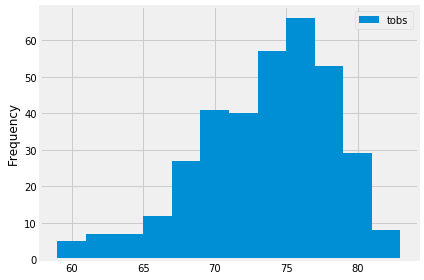

In [25]:
from pandas.plotting import table
df = pd.DataFrame(results, columns=['tobs'])
df.plot.hist(bins=12)
plt.tight_layout()

In [26]:
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()


print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [27]:
calc_temps("2017-02-14", "2017-02-25")

[(61.0, 71.16666666666667, 79.0)]

In [28]:
tmin, tavg,tmax =calc_temps("2017-02-15", "2017-02-25")[0]

In [29]:
print(tmin, tavg,tmax)

61.0 70.66666666666667 77.0


/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


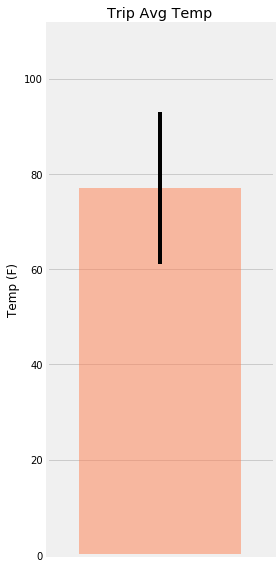

In [30]:
fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1
yerr = tmax-tmin

bar = ax.bar(xpos, tmax, yerr=yerr, alpha=0.5, color='coral', align="center")
ax.set(xticks=range(xpos), title="Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.2, .2)
# fig.autofmt_xdate()
fig.tight_layout()
fig.show()

In [31]:
vacat = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation,\
                     func.sum(Measurement.prcp)).filter(Measurement.date >= "2017-02-15").\
                     filter(Measurement.date <="2017-02-25").\
                     filter(Measurement.station == Station.station).\
                     group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()

vacat                        

[('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  1.02),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.87),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  0.8600000000000001),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.81),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.7899999999999999),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.23),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.17)]

In [36]:
def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [46]:
def daily_normals(date):
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all() 

normals = ["02-01", "02-02", "02-03", "02-04", "02-05", "02-06","02-07"]
for date in normals:
    print(daily_normals(date))         

[(56.0, 68.14035087719299, 78.0)]
[(59.0, 68.85964912280701, 77.0)]
[(58.0, 67.79661016949153, 77.0)]
[(61.0, 68.14035087719299, 76.0)]
[(59.0, 69.6842105263158, 80.0)]
[(58.0, 70.38983050847457, 77.0)]
[(60.0, 69.0, 77.0)]
